# Digital Signal & Image Processing Project 2023/2024

# Compression with Haar Wavelet Transform

Nowadays, when dealing with data transmission and storage, it's paramount to be able to compress it in order to diminish the amount of space it occupies and the time it takes to be transmitted. In this project we will see how to compress images using one of the different techniques available: the Haar Wavelet Transform (HWT). The HWT is not the best way to perform compression, but they're a good starting point to understand how 2D wavelets work and how they can be used to compress data. Notice that with HWT we can perform both lossy and lossless compression, depending on the threshold we choose. 

HWT basically relies on computing a sparse or nearly sparse matrix from the image matrix, in that these kind of matrices, having a great amount of entries to zero, can be stored in a more efficient way, leading to smaller file sizes. 

In order to understand how 2D HWT works, let's start with an example. Suppose we have the following matrix:

$$A = \begin{bmatrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{bmatrix} $$

and concentrate on the first row: $ \begin{bmatrix} 1 & 2 & 3 & 4 \end{bmatrix} $

The transformation is performed by applying the following steps:

1. Compute the average and the difference of each consecutive pair of elements in the row and store the averages in the first half of the row and the differences in the second half. In our example we obtain:

$$ r'_1 = \begin{bmatrix} 1.5 & 3.5 & -0.5 & -0.5 \end{bmatrix} $$ 
The first half of the row contains the so called approximation coefficients, while the second half contains the detail coefficients. Notice that the step is completely reversible, since we can obtain the original row by adding and subtracting the coefficients from the averages.

2. Repeat the same procedure again only on the first half of the row, obtaining:

$$ r''_1 = \begin{bmatrix} 2.5 & -1 & -0.5 & -0.5 \end{bmatrix} $$

Now for obvious reason we cannot procede further, since we have only four elements left, one approximation coefficient and three detail coefficients. Were we dealing with a longer row, we would repeat the same procedure again and again until we reach the desired level of compression.

Turning back to the matrix case, what we need to do is to apply the same procedure described above to all the rows and all the columns of the matrix. In this way we obtain a matrix with the same size of the original one, but with a lot of zero entries or entries very much close to zero:

$$ T = \begin{bmatrix} 8.4375 & -1.0625 & -0.625 & -0.5 \\ -3.9375 & 0.0625 & 0.125 & 0 \\-2 & 0 & 0 & 0 \\ -1.875 & 0.125 & 0.25 & 0 \end{bmatrix} $$

In fact, detail coefficients equal to zero describe regions of the image where the pixels were identical, while detail coefficients which are very close to zero describe regions of the image where the pixels were very similar.

##  1. Haar Wavelet Transformation Matrix

The procedure described in the previous section can be implemented by using a matrix multiplication. In fact, let's stick to the example above:

If we consider the following matrix $ H_1 = \begin{bmatrix} \frac{1}{2} & 0 & \frac{1}{2} & 0 \\ \frac{1}{2} & 0 & -\frac{1}{2} & 0 \\ 0 & \frac{1}{2} & 0 & \frac{1}{2} \\ 0 & \frac{1}{2} & 0 & -\frac{1}{2} \end{bmatrix} $ we might notice that $ H_1^{i} \cdot r_1 = r'_1 $, where $ H_1^{i} $ is the 1st row of $H$ and $ r_1 $ and $ r'_1 $ are the rows obtained in the previous section.

Analogously, if we consider the following matrix $ H_2 = \begin{bmatrix} \frac{1}{2} & \frac{1}{2} & 0 & 0 \\\frac{1}{2} & -\frac{1}{2} & 0 & 0 \\0 &  0 & 1 & 0\\0 & 0 & 0 & 1 \\ \end{bmatrix} $ we might notice that $ H_2^{i} \cdot r'_1 = r''_1 $, where $ H_2^{i} $ is the 1st row of $H_2$ and $ r''_1 $ is the row obtained in the previous section.

Finally, if we denote $H = H_1 \cdot H_2$, we can see that $H^T \cdot A \cdot H = T$, where $H$ is used to apply the procedure to the rows while $H^T$ is used to apply the procedure to the columns. The interesting part is that H is invertible and hence the procedure is, as we said, completely reversible. Hence: $ A = (H^{T})^{-1}\cdot T \cdot H^{-1} $.

This reasoning can of course be extended to the case in which $A$ is much bigger than the one in the example.

The main drawback when using matrices to compute the Haar Wavelet Transformation is that usually images are very big matrices, so the matrix $H$ is very big as well. This means that we need a lot of memory to store it and a lot of time to compute the inverse of $H$ in order to obtain the original image.

### 1.2 Implementation

Since I didn't want to compute very big $H$ matrices every time I was dealing with an image, I got inspired by block-based image compression and decided to divide the image matrix in 8 x 8 blocks (since it's a common standard dimension, in JPEG for instance) and compute the transformation on each of these. In this way it's more manageable and eventually better parallelizable, furthermore I can compute the transformation on small matrices and this allows me to use a smaller $H$ matrix, thus saving memory and time for the matrix inversion. The results obtained with this approach, regarding the compression, seems quite reasonable as we will see in the next section.

**PS:** if the image is not a multiple of 8, it's padded with zeros.

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import math

The following code is used to compute the transformation matrix H for 8 x 8 blocks, which is the result of the multiplication of $H_1$, $H_2$ and $H_3$. These are obtained using the function *H_i*, which takes in input three parameters: the matrix size, the number of the matrix we're computing and whether the coefficients are normalized or not (we'll talk about this later).

The matrices have the following form:

$ H_1 = \begin{bmatrix} \frac{1}{2} & 0 & 0 & 0 & \frac{1}{2} & 0 & 0 & 0 \\ \frac{1}{2} & 0 & 0 & 0 & -\frac{1}{2} & 0 & 0 & 0 \\ 0 & \frac{1}{2} & 0 & 0 & 0 & \frac{1}{2} & 0 & 0 \\ 0 & \frac{1}{2} & 0 & 0 & 0 & -\frac{1}{2} & 0 & 0 \\ 0 & 0 & \frac{1}{2} & 0 & 0 & 0 & \frac{1}{2} & 0 \\ 0 & 0 & \frac{1}{2} & 0 & 0 & 0 & -\frac{1}{2} & 0 \\ 0 & 0 & 0 & \frac{1}{2} & 0 & 0 & 0 & \frac{1}{2} \\ 0 & 0 & 0 & \frac{1}{2} & 0 & 0 & 0 & -\frac{1}{2} \end{bmatrix}, 
\ H_2 = \begin{bmatrix} \frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 & 0 & 0 & 0 \\ \frac{1}{2} & 0 & -\frac{1}{2} & 0 & 0 & 0 & 0 & 0 \\ 0 & \frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 & 0 & 0 \\ 0 & \frac{1}{2} & 0 & -\frac{1}{2} & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix},
\ H_3 = \begin{bmatrix} \frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 & 0 & 0 & 0 \\ \frac{1}{2} & -\frac{1}{2} & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} $

$ H = H_1 \cdot H_2 \cdot H_3 = \begin{bmatrix} \frac{1}{8} & \frac{1}{8} & \frac{1}{4} & 0 & \frac{1}{2} & 0 & 0 & 0 \\ \frac{1}{8} & \frac{1}{8} & \frac{1}{4} & 0 & -\frac{1}{2} & 0 & 0 & 0 \\ \frac{1}{8} & \frac{1}{8} & - \frac{1}{4} & 0 & 0 & \frac{1}{2} & 0 & 0 \\ \frac{1}{8} & \frac{1}{8} & -\frac{1}{4} & 0 & 0 & -\frac{1}{2} & 0 & 0 \\ \frac{1}{8} & -\frac{1}{8} & 0 & \frac{1}{4} & 0 & 0 & \frac{1}{2} & 0 \\ \frac{1}{8} & -\frac{1}{8} & 0 & \frac{1}{4} & 0 & 0 & -\frac{1}{2} & 0 \\ \frac{1}{8} & -\frac{1}{8} & 0 & -\frac{1}{4} & 0 & 0 & 0 & \frac{1}{2} \\ \frac{1}{8} & -\frac{1}{8} & 0 & -\frac{1}{4} & 0 & 0 & 0 & -\frac{1}{2} \end{bmatrix}$

In [281]:
def H_i(n, i, is_normalized):
    Hi = np.zeros((n,n))

    coeff = 2 if not is_normalized else math.sqrt(2)

    for r in range(0, n//2**(i-1)):
        j = r//2
        Hi[r, j] = 1/coeff
        Hi[r, j+n//(2**i)] = ((-1)**r)*1/coeff

    # Create an identity matrix with 1 only on the bottom half diagonal
    half_I = np.eye(n, dtype=int)
    # Determine the midpoint of the diagonal
    midpoint = n // 2**(i-1)
    # Set the first half of the diagonal to zero
    half_I[:midpoint, :midpoint] = 0

    Hi += half_I

    return Hi

In [282]:
block_length = 8

H1 = H_i(block_length, 1, False)
H2 = H_i(block_length, 2, False)
H3 = H_i(block_length, 3, False)
H = H1 @ H2 @ H3

print(H)

[[ 0.125  0.125  0.25   0.     0.5    0.     0.     0.   ]
 [ 0.125  0.125  0.25   0.    -0.5    0.     0.     0.   ]
 [ 0.125  0.125 -0.25   0.     0.     0.5    0.     0.   ]
 [ 0.125  0.125 -0.25   0.     0.    -0.5    0.     0.   ]
 [ 0.125 -0.125  0.     0.25   0.     0.     0.5    0.   ]
 [ 0.125 -0.125  0.     0.25   0.     0.    -0.5    0.   ]
 [ 0.125 -0.125  0.    -0.25   0.     0.     0.     0.5  ]
 [ 0.125 -0.125  0.    -0.25   0.     0.     0.    -0.5  ]]


## 2. Grayscale case

For simplicity, in this section we will consider only grayscale images. The extension to the RGB case is straightforward, as we will see in the next section.

### 2.1 Lossless Compression

We now begin by analyzing the lossless compression case, which is kind of trivial

(256, 256)


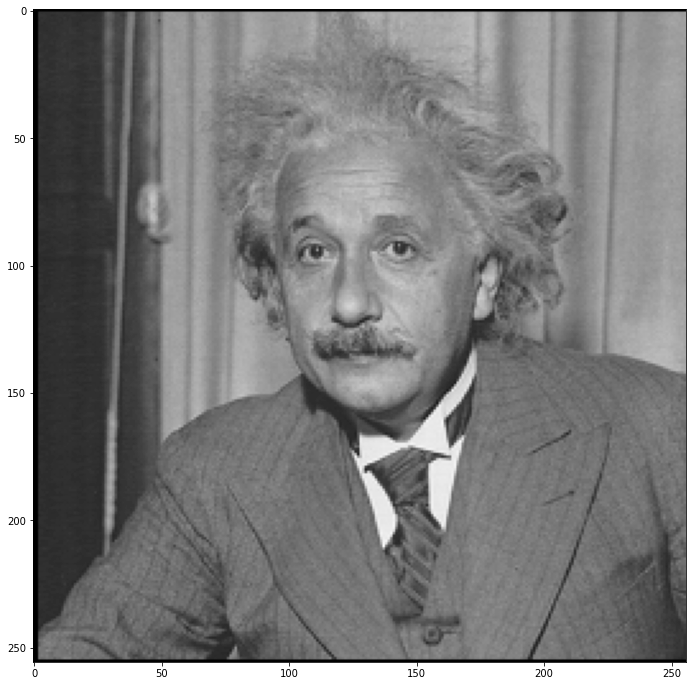

In [283]:
from skimage import data, io
img = io.imread("./grayscale/einstein.jpg")

plt.figure(figsize=(20, 12))
_ = plt.imshow(img, cmap='gray')
print(img.shape)

original_n, original_m = img.shape

Following we have the functions used for calculating the padding necessary to make the image size a multiple of 8, the function used to pad the image and the function used to remove the padding from this. Once the necessary padding is calculated, it's distributed equally (or almost in the odd case) on the left, right, top and bottom of the image.

In [284]:
def calc_padding(k):
    k_pad = (1 + k // 8)*8 - k if k % 8 else 0
    return math.floor(k_pad/2), math.ceil(k_pad/2)

def pad_img(img):
    n, m = img.shape[:2]
    before_n_pad, after_n_pad = calc_padding(n)
    before_m_pad, after_m_pad = calc_padding(m)

    img = np.pad(img, [(before_n_pad, after_n_pad), (before_m_pad, after_m_pad)], mode = 'constant') # type: ignore
    return img

def unpad_img(img, original_n, original_m):
    n, m = img.shape[:2]
    before_n_pad, after_n_pad = calc_padding(original_n)
    before_m_pad, after_m_pad = calc_padding(original_m)

    return img[before_n_pad:n-after_n_pad, before_m_pad:m-after_m_pad]

Following we have the functions used for compression and decompression; since the two operations are the same except for the matrices used for the transformation I defined three functions:

- *compression_decompression*: takes in input the image to transform, the matrix used to operate on the rows ($M$) and the one used to operate on the columns ($M^T$). It does the actual transformation, described before, on the image. Depending on the matrices used, the transformation will be either a compression or a decompression. Finally, the function returns the transformed image.

- *compression*: it's the function called when we want to compress an image, it takes in input the image to compress and the $H$ matrix. It essentially calls *compression_decompression* to do the actual work, but before this it pads the image as necessary.

- *decompression*: it's the function called when we want to decompress an image, it takes in input the image to decompress, the $H$ matrix and whether the transformation is normalized or not (we'll go over this further in the notebook). It essentially calls *compression_decompression* to do the actual work, with different matrices depending on whether we are in the normalized or non-normalized case, and after having decompressed the image, it unpads it as necessary.

In [285]:
def compression_decompression(img, M, M_T):
    n, m = img.shape
    transformed_img = np.zeros((n,m))

    for i in range(0, n, 8):
        for j in range(0, m, 8):
            A = img[i:i+8, j:j+8]
            B = M_T @ A @ M
            transformed_img[i:i+8, j:j+8] = B

    return transformed_img

def compression(img, H):
    padded_img = pad_img(img)
    return compression_decompression(padded_img, H, H.T)

def decompression(compressed_img, H, is_normalized):
    if is_normalized:
        decompressed_img = compression_decompression(compressed_img, H.T, H)
    else:
        decompressed_img = compression_decompression(compressed_img, np.linalg.inv(H), np.linalg.inv(H.T))
    
    return unpad_img(decompressed_img, original_n, original_m) if decompressed_img.shape != (original_n, original_m) else decompressed_img

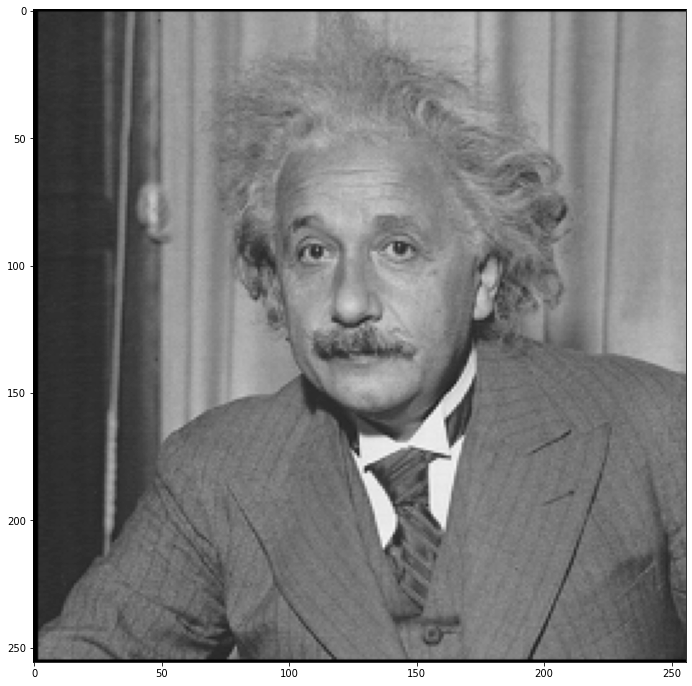

In [286]:
compressed_img = compression(img, H)

original_img = decompression(compressed_img, H, False)

plt.figure(figsize=(20, 12))
_ = plt.imshow(original_img, cmap='gray')

As we can notice, the compression was completely lossless, since we obtained the original image back.

The main drawback of this kind of compression with this technique is that the image is not that much compressed because it all depends on how much the compressed image is sparsed. If we want to properly diminish the size of the compress image, we need to turn to lossy compression.

### 2.2 Lossy Compression

Lossy compression is quite straightforward to implement starting from lossless compression. It essentially consists in setting a threshold and setting to zero all the coefficients of the transformed image whose absolute value is lower or equal to the threshold. In this way we obtain a very much sparse matrix (which is the sparser the higher the selected threshold) which occupies less space when stored. The drawback is that we are losing information when going back to the original image, since when we apply the thresholding operation we're effectively removing information.

Text(0.5, 1.0, 'Decompressed image with a threshold = 97th percentile')

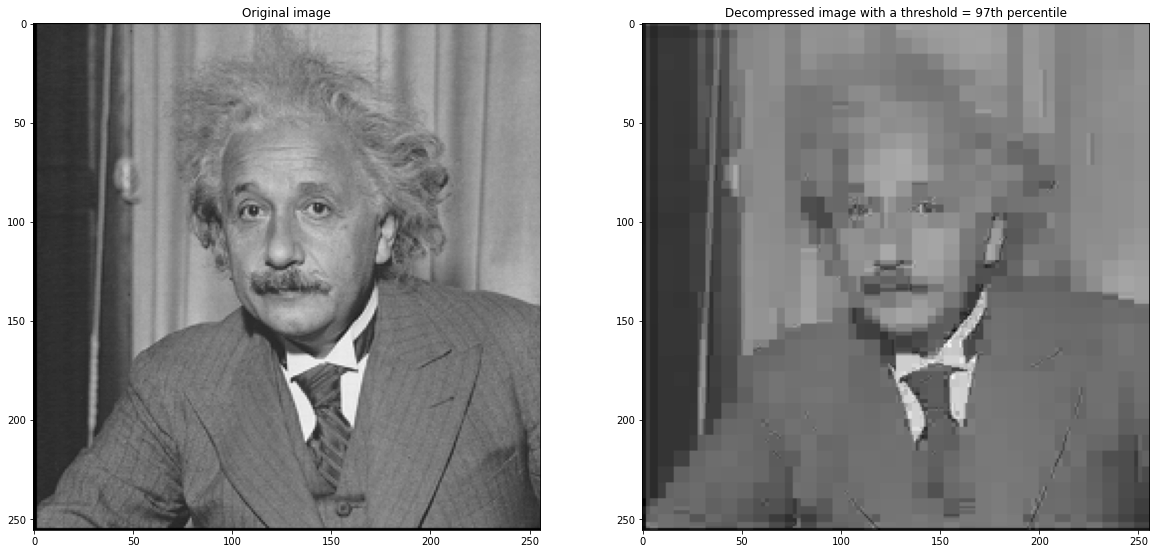

In [288]:
threshold_percentile = 97

thresholded_compressed_img = compressed_img.copy()
threshold = np.percentile(abs(thresholded_compressed_img), threshold_percentile)
thresholded_compressed_img[abs(thresholded_compressed_img) <= threshold] = 0

thresholded_decompressed_img = decompression(thresholded_compressed_img, H, False)

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(thresholded_decompressed_img, cmap='gray')
plt.title(f"Decompressed image with a threshold = {threshold_percentile}th percentile")

We can see that the image has been successfully compressed but at the same time, we've lost an incredible amount of information

### 2.3 Normalized version

We can actually improve the quality of our lossy compression with normalization. In fact, we can notice that the $H_i$ matrices have orthogonal columns, and hence $H$ is orthogonal. So, if we normalize these matrices and obtain an orthonormal transformation matrix $H$ we can usually achieve better quality because we are preserving angles and lengths. In doing so, we have another advantage: we don't need to compute the inverse of $H$ to decompress the image, since $H^{-1} = H^T$ if $H$ is orthonormal.

We can achieve normalization pretty easily, we just need to use $\frac{1}{\sqrt{2}}$ instead of $\frac{1}{2}$ as coefficients.

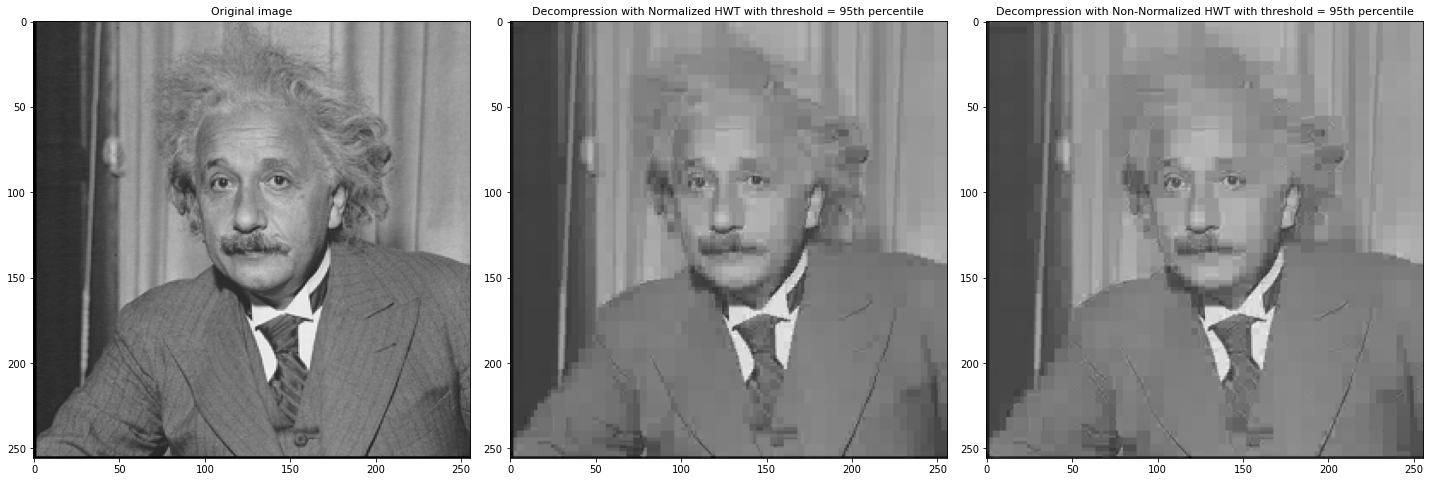

In [269]:
H1_normalized = H_i(block_length, 1, True)
H2_normalized = H_i(block_length, 2, True)
H3_normalized = H_i(block_length, 3, True)
H_normalized = H1_normalized @ H2_normalized @ H3_normalized

n, m = img.shape
norm_compressed_img = compression(img, H_normalized)
threshold_percentile = 95

thresholded_compressed_img = norm_compressed_img.copy()
threshold = np.percentile(abs(thresholded_compressed_img), threshold_percentile)
thresholded_compressed_img[abs(thresholded_compressed_img) <= threshold] = 0

norm_thresholded_decompressed_img = decompression(thresholded_compressed_img, H_normalized, True)

thresholded_compressed_img = compressed_img.copy()
threshold = np.percentile(abs(thresholded_compressed_img), threshold_percentile)
thresholded_compressed_img[abs(thresholded_compressed_img) <= threshold] = 0
thresholded_decompressed_img = decompression(thresholded_compressed_img, H, False)

plt.figure(figsize=(20, 12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original image", size = 11)
plt.subplot(1,3,2)
plt.title(f"Decompression with Normalized HWT with threshold = {threshold_percentile}th percentile", size = 11)
plt.imshow(norm_thresholded_decompressed_img, cmap='gray')
plt.subplot(1,3,3)
plt.title(f"Decompression with Non-Normalized HWT with threshold = {threshold_percentile}th percentile", size = 11)
plt.imshow(thresholded_decompressed_img, cmap='gray')

plt.tight_layout()

We can now see better the improvement in quality we obtain with normalization. In fact, if we compare the two images obtained with a threshold greater than the 95% of the pixels, we can see that the normalized one has a quality much better than the non-normalized one.

### 2.4 Compression ratios (CRs) and peak signal to noise ratios (PSNRs)

From now we'll only consider normalized lossy compression since it yields better performances than the non-normalized version. Let's see how much we can go further with compression without losing too much information such that the image is still recognizable. In order to do so, we need to define two metrics: the compression ratio (CR) and the peak signal to noise ratio (PSNR):

- The Compression Ratio is essentially how much we've compressed the image compared to the original one and, since we're dealing with sparse matrix, I defined it as the ratio between the number of non zero pixels in the compressed image without thresholding and the number of non zero pixels in the thresholded compressed image. The higher the CR, the more our image has been compressed.

- The Peak Signal to Noise Ratio is a metric used to measure the quality of the compressed image. It's defined as $PSNR = 10 \cdot \log_{10} \frac{MAX_I^2}{MSE}$, where $MAX_I$ is the maximum possible pixel value (in our case 255), and $MSE$ is the Mean Squared Error between the original image and the thresholded decompressed one. The lower the MSE, the higher the PSNR and hence the better the quality of the compressed image.

It's important to notice that the CR is not a good metric to measure the quality of the compressed image, since it doesn't take into account the quality of the image itself. In fact, we can have a very high CR but a very low PSNR, meaning that we've compressed the image a lot but we've lost a lot of information in doing so. On the other hand, we can have a very low CR but a very high PSNR, meaning that we've compressed the image very little but we've lost very little information in doing so. Hence it goes without saying that CR and PSNR are inversely proportional and needs to be considered together for a proper evaluation.

In [270]:
def compression_ratio(compressed_img, thresholded_compressed_img):
    return np.count_nonzero(compressed_img)/np.count_nonzero(thresholded_compressed_img)

In [271]:
def MSE(original_img, thresholded_original_img):
    return np.mean((original_img-thresholded_original_img)**2)

def PSNR(original_img, thresholded_original_img):
    return 20 * math.log10(255/math.sqrt(MSE(original_img, thresholded_original_img)))

Now we'll look at the transformation of the image with different thresholds and we'll see how the CR and the PSNR change

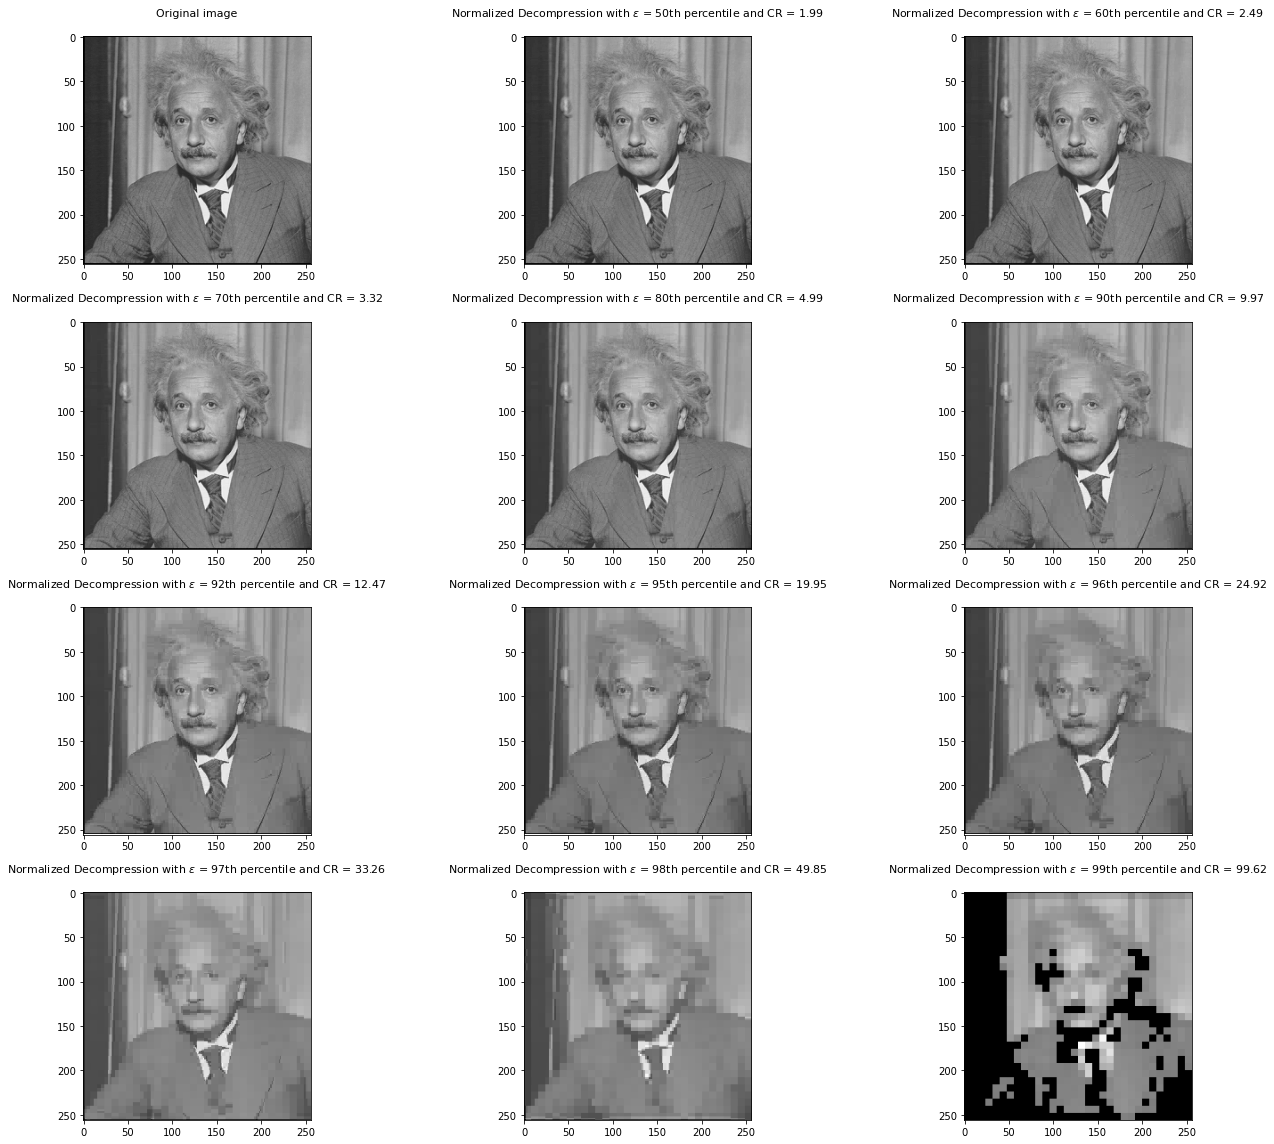

In [272]:
thresholds_percentile = [50, 60, 70, 80, 90, 92, 95, 96, 97, 98, 99]

n = 8

H1 = H_i(n, 1, True)
H2 = H_i(n, 2, True)
H3 = H_i(n, 3, True)
H = H1 @ H2 @ H3

n, m = img.shape
compressed_img = compression(img, H)
crs = []
psnrs = []
thresholded_compressed_imgs = [compressed_img]

plt.figure(figsize=(20, 16))
plt.subplot(len(thresholds_percentile)//3+1,3,1)
plt.title(f"Original image", pad = 20, size = 11)
_ = plt.imshow(img, cmap='gray')

for i, threshold_percentile in enumerate(thresholds_percentile):
    thresholded_compressed_img = compressed_img.copy()
    threshold = np.percentile(abs(thresholded_compressed_img), threshold_percentile)
    thresholded_compressed_img[abs(thresholded_compressed_img) <= threshold] = 0
    thresholded_compressed_imgs.append(thresholded_compressed_img)

    thresholded_original_img = decompression(thresholded_compressed_img, H, True)
    cr = round(compression_ratio(compressed_img, thresholded_compressed_img), 2)
    crs.append(cr)
    psnrs.append(PSNR(img, thresholded_original_img))

    plt.subplot(len(thresholds_percentile)//3+1,3,i+2)
    plt.title(f"Normalized Decompression with $\epsilon$ = {threshold_percentile}th percentile and CR = {cr}", pad = 20, size = 11)
    _ = plt.imshow(thresholded_original_img, cmap='gray')

plt.tight_layout()
plt.show()

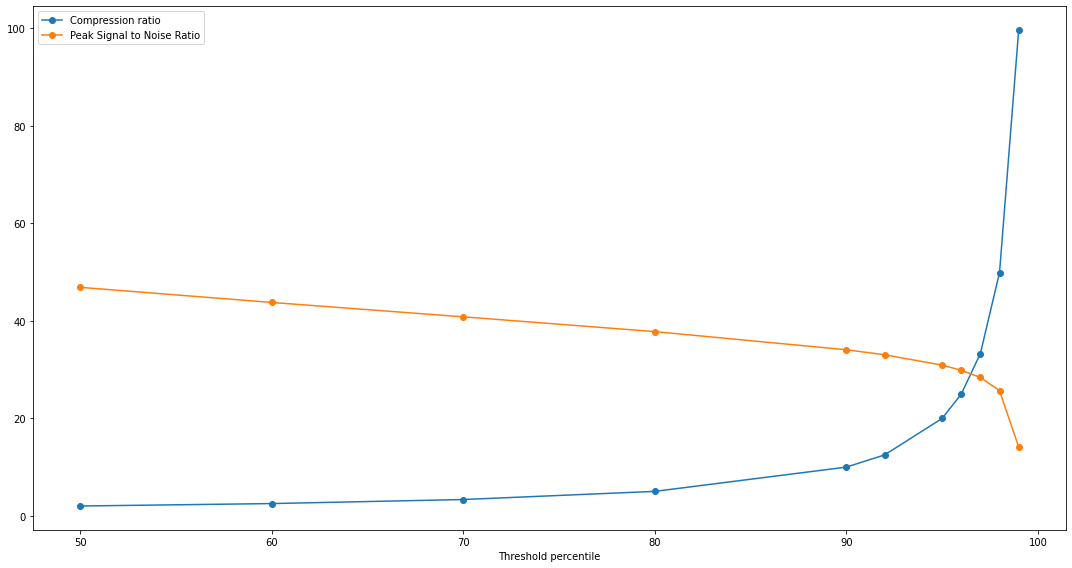

In [273]:
plt.figure(figsize=(15, 8))
plt.plot(thresholds_percentile, crs, label = "Compression ratio", marker = "o")
plt.plot(thresholds_percentile, psnrs, label = "Peak Signal to Noise Ratio", marker = "o")
plt.legend(loc="best")
plt.xlabel("Threshold percentile")
plt.tight_layout()
plt.show()

We can notice from the plot what stated before: CR and PSNR are inversely proportional. Hence, we need to find a good tradeoff between the two metrics. In this case, the best tradeoff seems to be betweend the 96th and the 97th percentiles, as backed up by the plots above: we consistently compress our image without losing too much information.

### 2.5 Progressive Image Transmission (PIT)

Now, I wanted to simulate the progressive transmission of the image. In particular, starting from a very much thresholded compressed image (low quality), it's possible to go back to the original one starting from the more compressed version and going back just by adding the details coefficients that had been zeroed out from the previous thresholding step. 

This is useful in case of transmission of images over a network, where the image can be sent in a low quality version first, and then, if the user wants, the image can be sent in a better quality version.

#### 2.5.1 Sender

We simulate the transmission by having a buffer with just the last thresholded compressed image and all the progressive missing details

In [274]:
buffer = [thresholded_compressed_imgs[-1]]
thresholded_compressed_imgs = list(reversed(thresholded_compressed_imgs))
for i, compressed_img in enumerate(thresholded_compressed_imgs[1:]): # type:ignore
    buffer.append(compressed_img - thresholded_compressed_imgs[i])

#### 2.5.2 Receiver

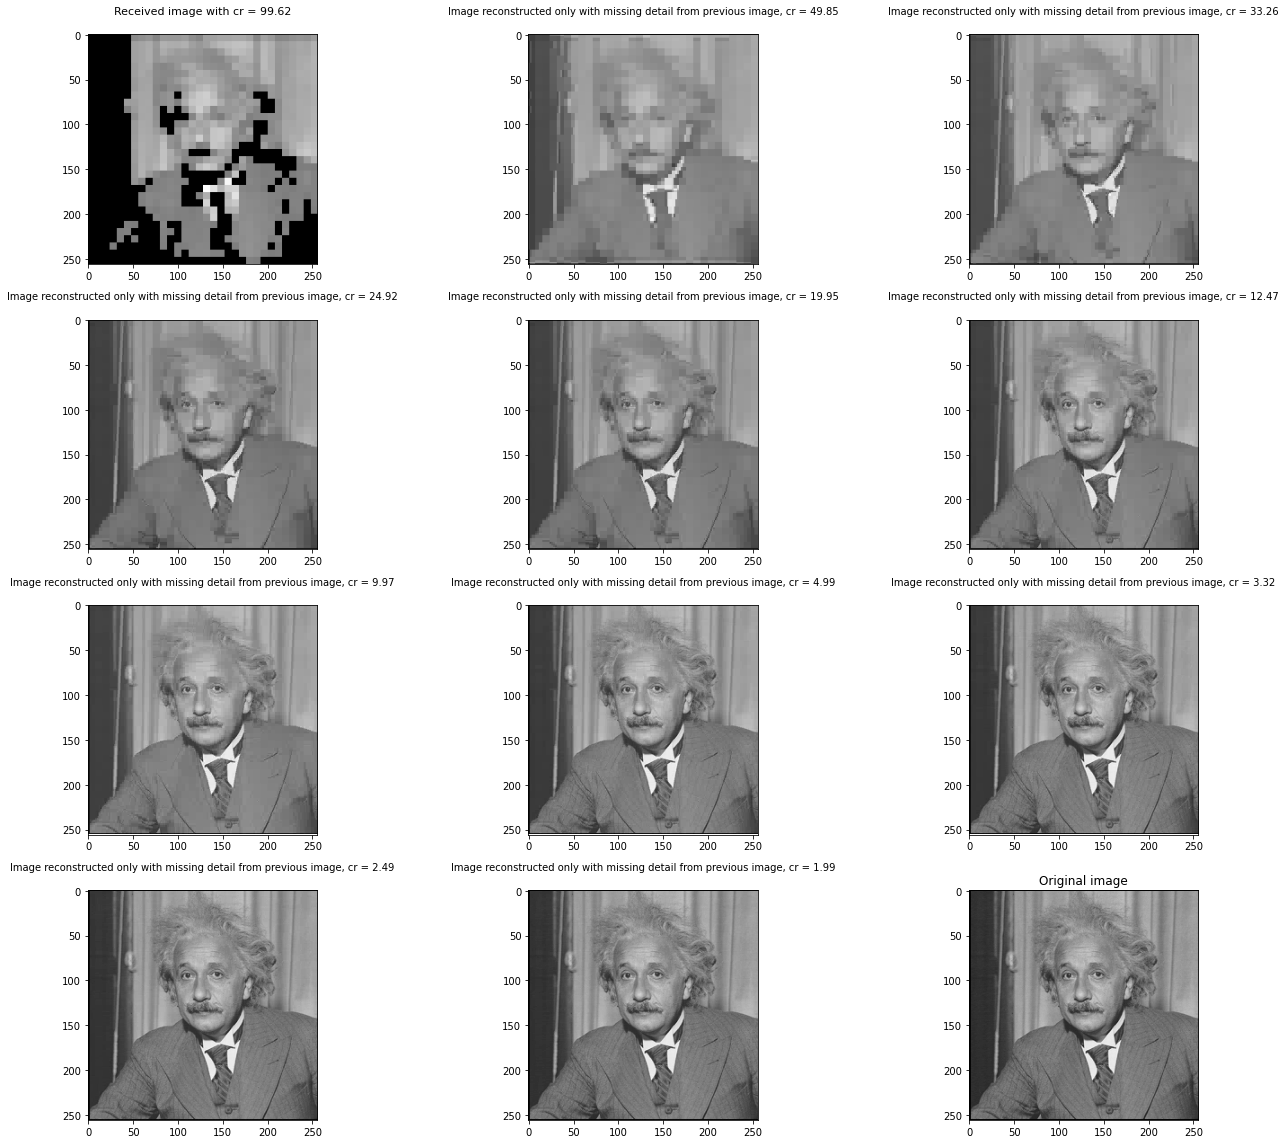

In [275]:
compressed_img = buffer[0].copy()
rev_crs = list(reversed(crs))

plt.figure(figsize=(20, 16))
plt.subplot(len(buffer)//3,3,1)
plt.title(f"Received image with cr = {rev_crs[0]}", pad = 20, size = 11)
plt.imshow(decompression(compressed_img, H, True), cmap="gray")

for i, missing_details in enumerate(buffer[1:]):
    compressed_img += missing_details
    plt.subplot(len(buffer)//3,3,i+2)
    if i+2 == len(buffer):
        plt.title("Original image")
    else:
        plt.title(f"Image reconstructed only with missing detail from previous image, cr = {rev_crs[i+1]}", pad = 20, size = 10)
    
    plt.imshow(decompression(compressed_img, H, True), cmap="gray")

plt.tight_layout()
plt.show()

We can indeed notice that starting from the greatest compressed image received, we can go back to the original one by just progressively adding to the current reconstructed image the details coefficients that had been zeroed out in the previous thresholding step.

## 3. RGB case

Let's now consider the RGB case

(300, 451, 3)

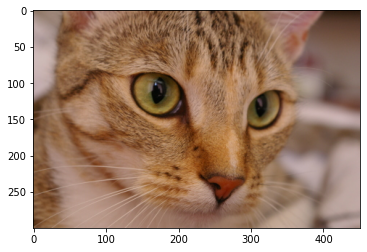

In [289]:
img = data.chelsea()
_ = plt.imshow(img)
original_n, original_m, _ = img.shape
img.shape

### 3.1 Compression and Decompression

The main difference in the RGB case is that we need to compress and decompress 3 different images instead of one. Hence, we need to apply the transformation to each of the three channels and then recompose the image. The compression and decompression functions defined below essentially calls the analogous functions defined in the grayscale case for each of the three channels.

In [290]:
def compression_rgb(img, H):
    first_slice = compression(img[:,:,0], H)
    n, m = first_slice.shape # this is done in order to obtain n and m for the initialization of compressed_img: we don't know its dimensions due to the padding
    compressed_img = np.zeros((n, m, 3))
    compressed_img[:,:,0] = first_slice
    compressed_img[:,:,1] = compression(img[:,:,1], H)
    compressed_img[:,:,2] = compression(img[:,:,2], H)

    return compressed_img

def decompression_rgb(compressed_img, H, is_normalized):
    first_slice = decompression(compressed_img[:,:,0], H, is_normalized)
    n, m = first_slice.shape # this is done in order to obtain n and m for the initialization of decompressed_img: we don't know its dimensions due to the padding
    decompressed_img = np.zeros((n, m, 3))
    decompressed_img[:,:,0] = first_slice
    decompressed_img[:,:,1] = decompression(compressed_img[:,:,1], H, is_normalized)
    decompressed_img[:,:,2] = decompression(compressed_img[:,:,2], H, is_normalized)

    return decompressed_img.astype('uint8')

### 3.2 Normalized vs Non-normalized

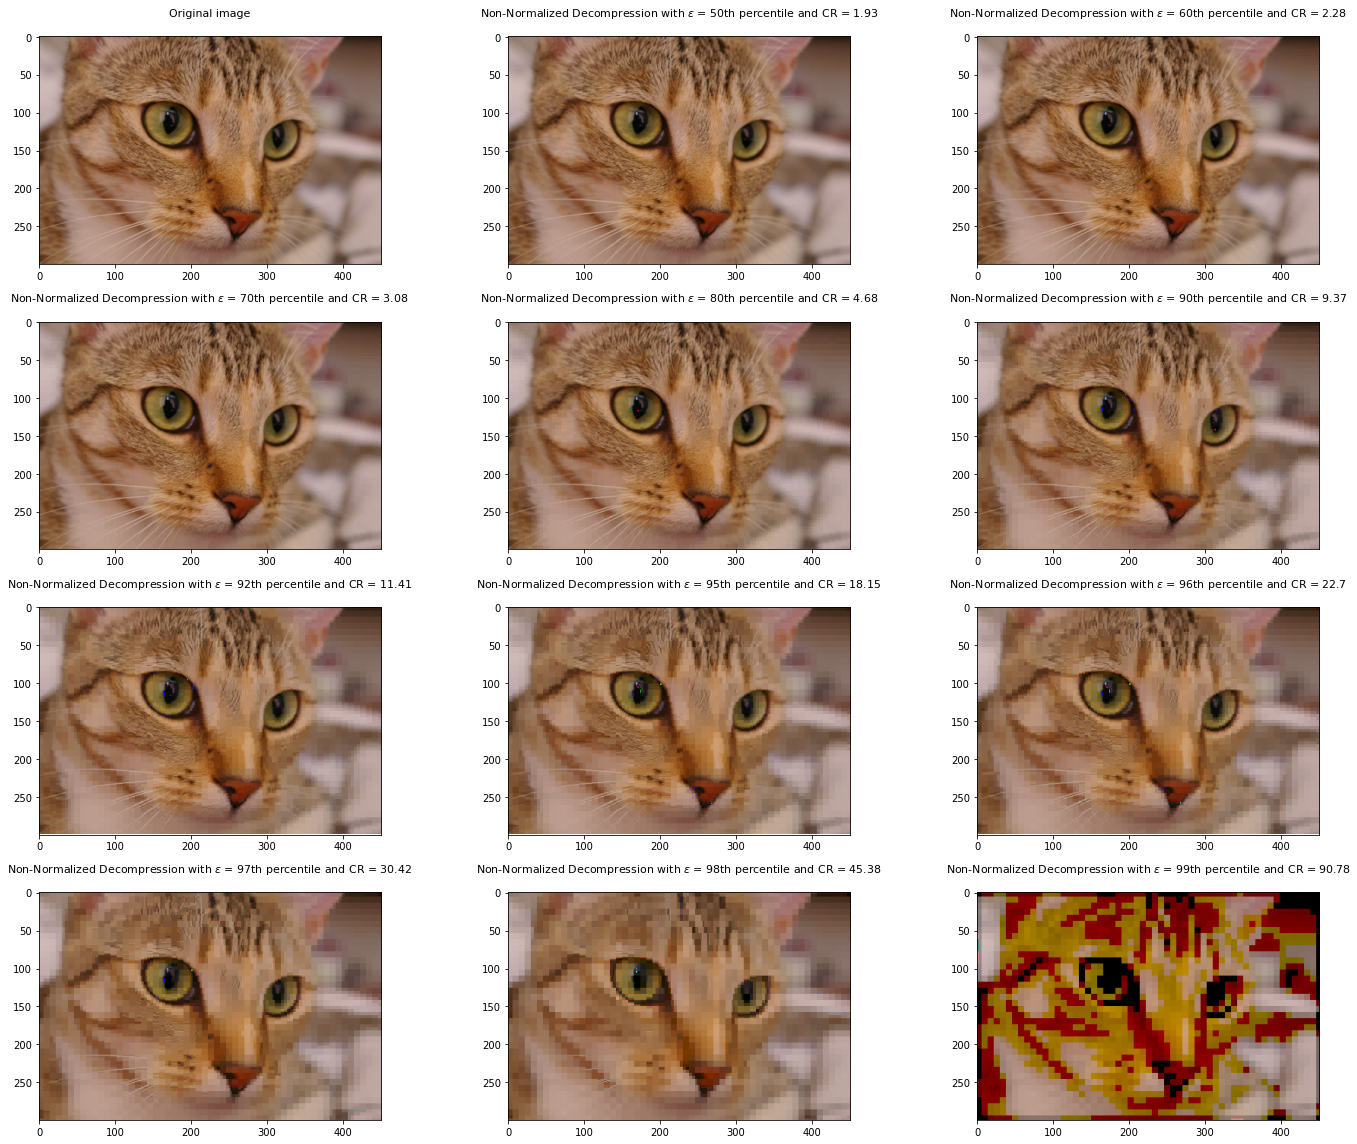

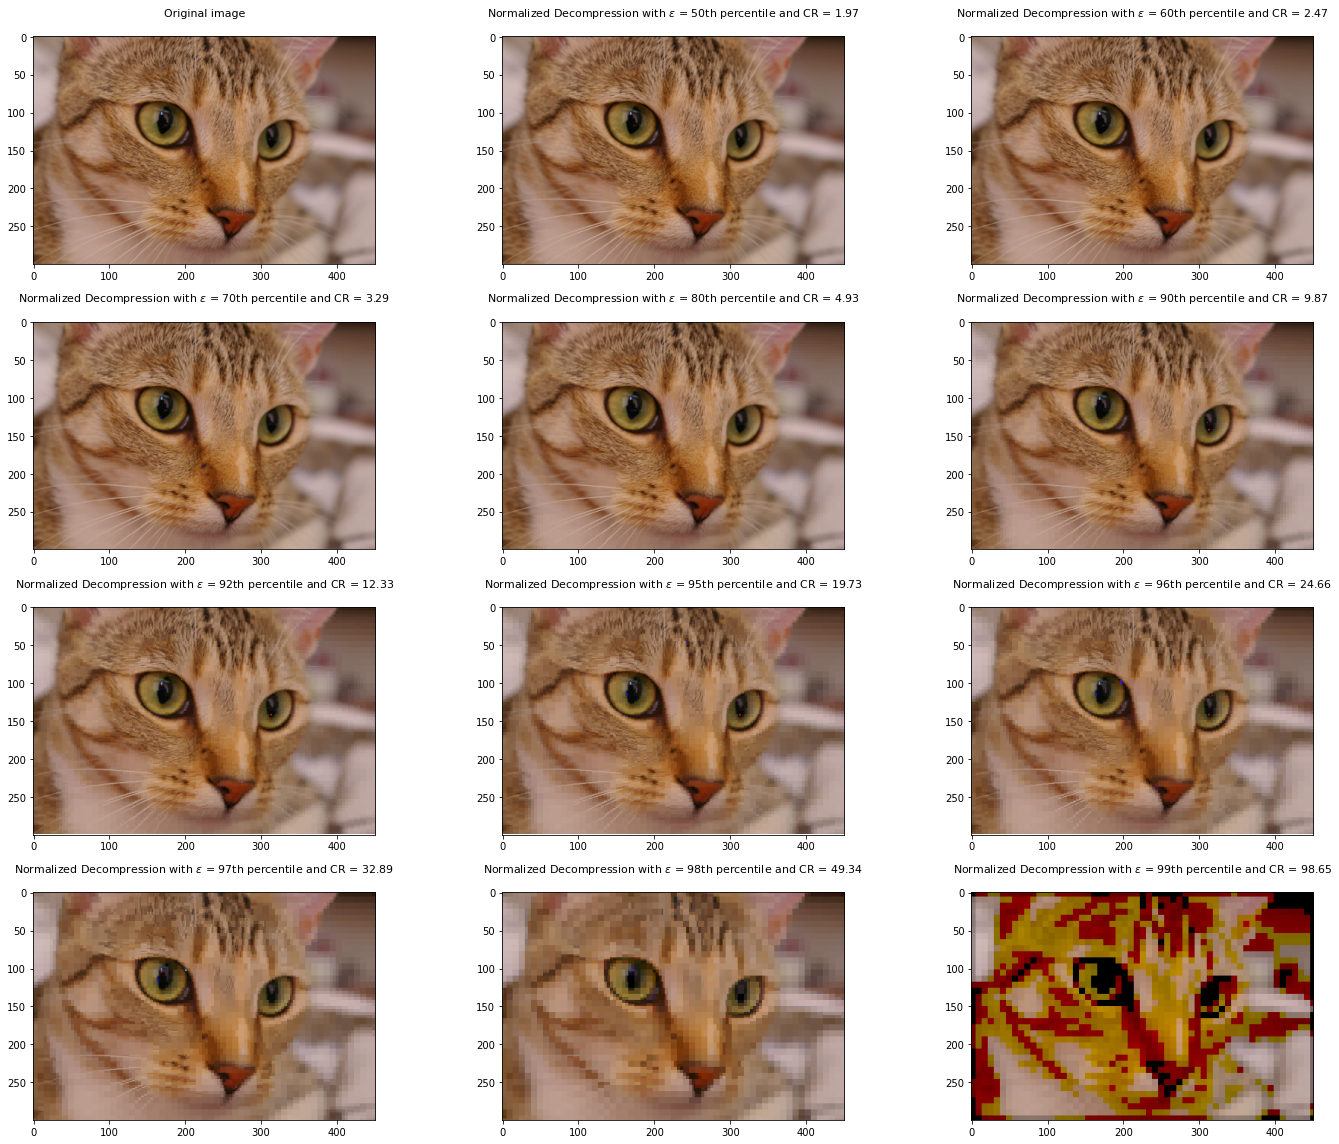

In [291]:
thresholds_percentile = [50, 60, 70, 80, 90, 92, 95, 96, 97, 98, 99]
n = 8
normalization = [False, True]
f = []
for is_normalized in normalization:

    H1 = H_i(n, 1, is_normalized)
    H2 = H_i(n, 2, is_normalized)
    H3 = H_i(n, 3, is_normalized)
    H = H1 @ H2 @ H3

    compressed_img = compression_rgb(img, H)
    crs = []
    psnrs = []
    thresholded_compressed_imgs = [compressed_img]

    plt.figure(figsize=(20, 16))
    plt.subplot(len(thresholds_percentile)//3+1,3,1)
    plt.title(f"Original image", pad = 20, size = 11)
    _ = plt.imshow(img, cmap='gray')

    for i, threshold_percentile in enumerate(thresholds_percentile):
        thresholded_compressed_img = compressed_img.copy()
        threshold = np.percentile(abs(thresholded_compressed_img.ravel()), threshold_percentile)
        thresholded_compressed_img[abs(thresholded_compressed_img) <= threshold] = 0
        thresholded_compressed_imgs.append(thresholded_compressed_img)

        thresholded_original_img = decompression_rgb(thresholded_compressed_img, H, is_normalized)
        cr = round(compression_ratio(compressed_img, thresholded_compressed_img), 2)
        crs.append(cr)
        psnrs.append(PSNR(img, thresholded_original_img))

        if i == 0 and not is_normalized:
            f.append(thresholded_original_img)
        
        if i == 4 and is_normalized:
            f.append(thresholded_original_img)

        plt.subplot(len(thresholds_percentile)//3+1,3,i+2)
        plt.title(f"{'' if is_normalized else 'Non-'}Normalized Decompression with $\epsilon$ = {threshold_percentile}th percentile and CR = {cr}", pad = 20, size = 11)
        _ = plt.imshow(thresholded_original_img)

    plt.tight_layout()
    plt.show()

In the RGB case we can notice the effect of normalization as well, especially if we look carefully at the nose of the cat: in the normalized case it gets less blurry and more defined than in the non-normalized one at the same percentile threshold.

### 3.3 Compression ratios (CRs) and peak signal to noise ratios (PSNRs)

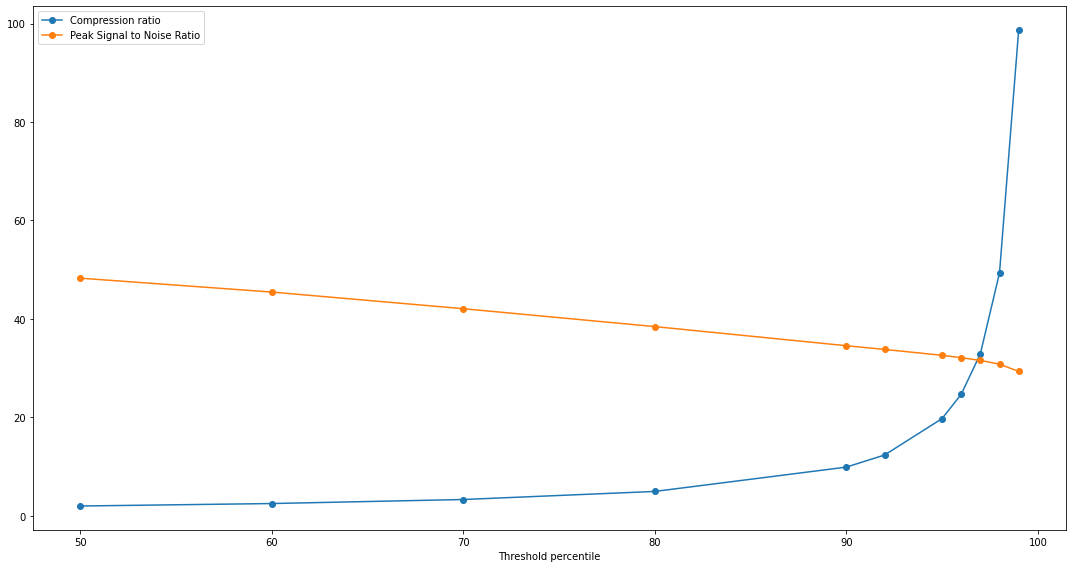

In [292]:
plt.figure(figsize=(15, 8))
plt.plot(thresholds_percentile, crs, label = "Compression ratio", marker = "o")
plt.plot(thresholds_percentile, psnrs, label = "Peak Signal to Noise Ratio", marker = "o")
plt.legend(loc="best")
plt.xlabel("Threshold percentile")
plt.tight_layout()
plt.show()

Nothing interesting to say about CR and PSNR, they behave in the same way as in the grayscale case, if not for some values that are a bit greater.

## 4. Conclusions

The HWT effectively compresses images in a reasonable way, but only when we adopt lossy compression because the lossless one doesn't perform such a good job. The problem with lossy compression is that we have a trade-off between CR and PSNR, so we have to find a good compromise between the two: we want to compress our image as much as possible, but we also want to keep the quality of the image as high as possible. This is of course doable, but obviously if we want to consistensly compress the image, we have to accept a certain loss of quality.

Overall, 2D HWT is a reasonable technique in order to compress data since they’re easy to understand, to implement and they yield fair results. The main issue is that lossless compression isn't that useful, since it doesn't compress the image that much, and lossy compression is effective to the detriment of quality.

There are better alternatives: Daublechies, Coiflets and Biorthogonal wavelets are a good match for instance, but they're obviously more complex to implement and to understand. If you don't want to stick with wavelets instead, your best bet should be the discrete cosine transform.